Program started!
Connecting railway website...
Total: 252 pages
Fetching...


 58%|██████████████████████████████████████████████▋                                 | 147/252 [03:09<01:24,  1.24it/s]

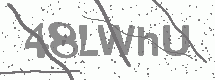

Solve the captcha to continue:48LWhu
Success~! Continue fetching...


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [07:02<00:00,  1.08s/it]


Writing data to file...
Done!
Connecting mrt website...
Start fetching...


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:08<00:00,  4.46it/s]


Writing to file...
Done!


In [12]:
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from getpass import getpass
from tqdm import tqdm
from time import sleep,ctime
from PIL import Image
from IPython.display import display
import pandas as pd
import csv, requests, re, os, MySQLdb

headers = {'user-agent': 'Mozilla/5.0 (Macintosh Intel Mac OS X 10_13_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.181 Safari/537.36'}
driver_path = 'C:\\driver\\chromedriver.exe'


def db_connector():
    conn = MySQLdb.connect(host='localhost',user='test',passwd='%s'%getpass('DB password: '),db='lost_props',charset='utf8')
    cursor = conn.cursor()
    return conn, cursor

def db_writer():
    print('Opening total_records file...')
    with open('total_records1.csv', 'rt', encoding='utf_8_sig') as file:
        line = file.readline()
        lines = file.readlines()
        print('Writing to database...')
        for item in lines:
            item = item.rstrip('\n')
            item = item.split(',')
            try:
                cursor.execute('INSERT INTO lost_props(DATE,SOURCE,ORIGIN_INDEX,FOUND_LOCATION,ITEM_TYPE,ITEM_DETAIL,KEEP_AGENCY,ANNOUNCE_AGENCY,CONTACT) VALUES("%s", "%s", "%s", "%s", "%s", "%s", "%s", "%s", "%s")',item)
            except:
                pass
        conn.commit()
        cursor.close()
        print('Done!')
    
def railway_fetcher():
    list_items = []
    lost_items = browser.find_elements_by_xpath('//tr[@class="gray01 text_12_1pt form01" or @class="gray01 text_12_1pt form02"]')
    for item in lost_items: 
        item = item.text.split(' ')
        for i in range(len(item)-4):
            if item[i] == '' and item[i+1] == '':
                item.pop(i)
        if item[-1:] == ['']:
            item.pop(-1)
        if len(item) > 9:
            blank = ' '
            discription = item[5:-3]
            item[5] = blank.join(discription)
            item[5] = item[5].replace(',', ' ')
            item = item[:6] + item[-3:]
        list_items.append(item)
    return list_items

def captcha_solver():
    browser.get('http://163.29.186.138/tw/lost_List.aspx') #利用截圖將captcha圖片載回本地讓使用者作答，可直接接上付費解碼API
    browser.save_screenshot('srcsht.png')
    captcha = browser.find_element_by_xpath('//img[@alt="Red dot"]')
    left = captcha.location['x']
    right = captcha.location['x'] + captcha.size['width']
    top = captcha.location['y']
    bottom = captcha.location['y'] + captcha.size['height']
    img = Image.open('srcsht.png')
    img = img.crop((left, top, right, bottom))
    img.save('captcha.png', 'png')
    display(Image.open('captcha.png'))
    input_box = browser.find_element_by_xpath('//input[@id="ans"]')
    submit_button = browser.find_element_by_xpath('//button[@id="jar"]')
    solution = input('Solve the captcha to continue:')
    input_box.send_keys(solution)
    submit_button.click()
    print('Success~! Continue fetching...')
        

def railway():
    print('Connecting railway website...')
    browser.get('http://163.29.186.138/tw/lost_List.aspx') #打開台鐵管理局

    total_data = []
    page_info = browser.find_element_by_xpath('//span[@id="PageInfo"]')
    pages = int(re.findall(r'(?<=\/ )\d*(?= 頁)', page_info.text)[0]) #找到台鐵資料總頁數
    print('Total: %s pages'%pages)

    print('Fetching...')
    for page in tqdm(range(1, pages+1)):
        if page == 1:
            total_data.extend(railway_fetcher())
        else:
            page = str(page)
            try:
                select = Select(browser.find_element_by_name('PageList')) #選取換頁選單
            except:
                sleep(3)
                browser.get('http://163.29.186.138/tw/lost_List.aspx')
                captcha_solver() #處理防機器人機制出現
                select = Select(browser.find_element_by_name('PageList'))
            select.select_by_value(page)
            total_data.extend(railway_fetcher())

    print('Writing data to file...')
    with open('railway_data.csv', 'w', encoding='utf-8-sig', newline='') as csvfile:
        writer= csv.writer(csvfile)
        writer.writerow(['index','paper_index','date','found_location','item_type','item_detail','keep_agency','anounce_agency','contact'])
        writer.writerows(total_data)
    total_writer.writerows(standard(total_data))
    browser.close()
    print("Done!")

def mrt():
    print('Connecting mrt website...')
    url = 'https://web.metro.taipei/c/lf2016result.asp?targetAction=item&targetPlace=H&targetItem='

    total_data = []
    print('Start fetching...') #item_type:針對網站上所有類別進行遞迴
    item_types = tqdm(['紙袋','背包','手提袋','文件袋','行李箱','紙箱','現金','手錶','皮夾','照相機','行動電話','金融卡','信用卡','存摺','票據','證件','首飾','筆電平板','其它個資3C產品','印章','車票夾','眼鏡','電子票證','鑰匙','零錢包','鉛筆盒','記事本','電話卡','電話本','照片','書','衣物','帽子','鞋子','圍巾','手套','絲巾','領帶','腰帶','安全帽','長傘','摺傘','水壺','保溫瓶','便當盒','玩具','玩偶','他類'])
    for keyword in item_types:
        conn = requests.get('https://web.metro.taipei/c/lf2016result.asp?targetAction=item&targetPlace=H&targetItem=%s'%keyword, headers=headers)
        conn.encoding = 'utf-8'
        website = conn.text
        try:
            df = pd.read_html(website)[0]
            df = df.where((pd.notnull(df)), '')
            item_list = df.values.tolist()
            total_data.extend(item_list)
        except ValueError:
            pass
    print('Writing to file...')
    with open('mrt_data.csv', 'w', encoding='utf-8-sig', newline='') as csvfile:
        writer= csv.writer(csvfile)
        writer.writerow(['date','item_name', 'found_location', 'index', 'keep_agency'])
        writer.writerows(total_data)
    total_writer.writerows(standard(total_data))
    print('Done!')

def standard(data):
    data_standarized = [] #將不同來源的資料做標準化以便整合
    if len(data[0]) == 9:
        for item in data:
            item_standarized = [item[2],'railway',item[0]]
            item_standarized.extend(item[3:])
            data_standarized.append(item_standarized)
        return data_standarized
    elif len(data[0]) ==5:
        for item in data:
            item_standarized = [item[0], 'mrt', item[3], item[2], item[1], item[1], item[4], '', '']
            data_standarized.append(item_standarized)
        return data_standarized

def dump_total():
    total_records = open('total_records.csv','w', encoding='utf_8_sig', newline='')
    total_writer = csv.writer(total_records)
    total_writer.writerow(['DATE','SOURCE','ORIGIN_INDEX','FOUND_LOCATION','ITEM_TYPE','ITEM_DETAIL','KEEP_AGENCY','ANNOUCE_AGENCY','CONTACT'])
    return total_records, total_writer



if __name__ == '__main__':
    print('Program started!')
    browser = webdriver.Chrome(driver_path)
    total_records, total_writer = dump_total()
#     conn, cursor = db_connector()
    railway()
    mrt()
#     db_writer()
    total_records.close()